Matt Dula

Collaborators: Cory Hilton, Anton Schlegel, Derek Bowman

# Improving Performance with NumPy and Pandas

NumPy, Pandas, and other packages in the scientific Python ecosystem provide a huge variety of tools that make common research tasks simpler. Generally, its best to use these tools as they have been specially optimized; however, there can be reasons to prefer code that takes slightly longer to run. Sometimes performant code is hard to read. Other times, developers may have had other goals in mind, and don't prioritize performance. **Always, always test your code changes to ensure you're actually seeing an improvement** (and that your results are correct).

The code used in this workbook is modified from [High Performance Python by Gorelick & Ozsvald](https://github.com/mynameisfiber/high_performance_python_2e/tree/master/06_matrix).

---
## Refactoring Lists to NumPy Arrays



Last week we learned that NumPy arrays can take advantage of vectorization to efficiently perform mathematical operations on lost of (homogenous) data. The goal of this section is to provide experience converting an existing list-based code to use NumPy. It also introduces NumPy array slicing - another way NumPy leverages vectorization.

The code below simulates a simple 1D diffusion problem. Entries in a list function as cells in a grid,
where each cell's value represents the concentration of a fluid at a point in space. Over time, the concentration in each cell will change as the fluid redistributes. **You will be incrementally refactoring this list-based code to use NumPy.**

A small region near the center of the grid is given a higher concentration than its surroundings:

![Graph of the initial conditions for our sample 1D diffusion problem.](diffusion_ICs.png "Diffusion Initial Conditions")

After 500 iterations with the default parameters, the concentration smooths out:

![Graph of the diffusion problem after 500 iterations.](diffusion_updated.png "Diffusion After 500 Iterations")

### Algorithm Description

Each entry in the list `grid` corresponds to some coordinate along the $x$ axis, such that the $i$ th cell of `grid` corresponds to position $x_{i}$.
The concentration C at position $x_i$ --- or $C(x_i)$ ---  is then stored as `grid[i]`. 

Each time we update the grid --- taking a timestep `dt` --- we iterate over all the cells in the grid. To update the value of each cell,
we apply a "stencil" which combines information from neighboring cells in a weighted manner.

For cell $i$, the stencil uses data from cells $i-1$ and $i+1$ to approximate the second derivative of the concentration $C$:

$\frac{dC}{dt} = D \cdot \frac{d^2}{dx^2} C(x) \approx D \cdot \left( C(x_{i-1}) + C(x_{i+1}) - 2 C(x) \right)$

where $D$ is the diffusion coefficient.

Below is an example grid. The stencil is shown in blue. The red cells are special cells called "ghost zones." These cells exist so that the stencil can still be applied to the edges of the grid. Information in ghost zones is usually ignored when analyzing the results of simulations like this 1D diffusion problem, but are **very** important to the correct function of the diffusion algorithm.

![Diagram the stencil-based grid update and ghost zones](stencil.png)



In [6]:
import numpy as np

In [3]:
def run_simulation(grid_size = 600, 
                   dt = 0.1,
                   num_iterations = 500,
                   diffusion_coeff = 1.0):
    """
    Simulate the diffusion of a fluid in 1D using lists.
    
    grid_size: the number of cells in our grid.
    dt: time change for each iteration
    num_iterations: how many time steps we allow the fluid to diffuse.
    diffusion_coeff: diffusivity of the fluid; higher is more diffusive.

    Returns the state of the grid after num_iterations
    """

    # Construct 1D grid
    # Add an additional cell at each end to handle grid boundaries
    # grid[0] and grid[grid_size+1] are these boundary cells
    grid = [0.01] * (grid_size + 2)

    # Set the initial conditions
    # A small region (~10% of total length)
    # near the middle has high concentration
    start_index = int(grid_size * 0.4)
    end_index = int(grid_size * 0.5)
    for i in range(start_index+1, end_index+1):
        grid[i] = 0.02

    # Evolve the grid
    for t in range(num_iterations):

        # create a new grid to store updates
        new_grid = [0.0] * (grid_size + 2)

        # update main grid
        for i in range(1, grid_size+1):
            stencil = grid[i+1] + grid[i-1] - 2*grid[i]
            new_grid[i] = grid[i] + diffusion_coeff * stencil * dt

        # update boundary cells
        new_grid[0] = new_grid[1]
        new_grid[grid_size+1] = new_grid[grid_size]

        # swap new_grid and grid
        grid, new_grid = new_grid, grid

    return grid


---
### Exercises

1. Time `run_simulation` to establish a baseline. You can use the default arguments.

In [4]:
%timeit run_simulation()

56 ms ± 107 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Timing result: 49.7ms +/- 625us per loo (mean, st.dev. of 7 runs, 10 loops each)

2. Use `lprun` to profile the existing list-based version of `run_simulation`. Even though all of our code is in a single function, you will still need to specify the `-f` argument. The following questions will require the profiling output to answer.

In [5]:
%load_ext line_profiler
%lprun -f run_simulation run_simulation()

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Timer unit: 1e-09 s

Total time: 0.303292 s
File: /tmp/local/43781384/ipykernel_3748365/1180214463.py
Function: run_simulation at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def run_simulation(grid_size = 600, 
     2                                                              dt = 0.1,
     3                                                              num_iterations = 500,
     4                                                              diffusion_coeff = 1.0):
     5                                               """
     6                                               Simulate the diffusion of a fluid in 1D using lists.
     7                                               
     8                                               grid_size: the number of cells in our grid.
     9                                               dt: time change for each iteration
    10                                             

3. Which lines take the largest fraction of the overall runtime? What purpose do these lines serve?

Lines 36-38 take almost the entire fractional time of the overall runtime. These lines are to iteratively update the grid using a list-based method.

4. Which lines take the most amount of time *per hit*? Is there a common theme between these lines? Think about memory --- allocation, access, data movement, etc.

Lines 19 and 33 take the most amount of time per hit. This is because they are creating lists, which requires allocation of lots of memory, moving many addresses into the cache, and setting the values at those addresses to the desired values.

5. Defining a new function, convert `grid` and `new_grid` to NumPy arrays (recall the [array creation](https://numpy.org/doc/1.25/reference/routines.array-creation.html#numerical-ranges) routines). Check the results against the figures shown above and time your refactor. Is this version of the code slower or faster? Why do you think that is?

In [6]:
def run_simulation2(grid_size = 600, 
                   dt = 0.1,
                   num_iterations = 500,
                   diffusion_coeff = 1.0):
    """
    Simulate the diffusion of a fluid in 1D using lists.
    
    grid_size: the number of cells in our grid.
    dt: time change for each iteration
    num_iterations: how many time steps we allow the fluid to diffuse.
    diffusion_coeff: diffusivity of the fluid; higher is more diffusive.

    Returns the state of the grid after num_iterations
    """

    # Construct 1D grid
    # Add an additional cell at each end to handle grid boundaries
    # grid[0] and grid[grid_size+1] are these boundary cells
    grid = np.zeros(grid_size + 2) + 0.01

    # Set the initial conditions
    # A small region (~10% of total length)
    # near the middle has high concentration
    start_index = int(grid_size * 0.4)
    end_index = int(grid_size * 0.5)
    for i in range(start_index+1, end_index+1):
        grid[i] = 0.02

    # Evolve the grid
    for t in range(num_iterations):

        # create a new grid to store updates
        new_grid = np.zeros(grid_size + 2)

        # update main grid
        for i in range(1, grid_size+1):
            stencil = grid[i+1] + grid[i-1] - 2*grid[i]
            new_grid[i] = grid[i] + diffusion_coeff * stencil * dt

        # update boundary cells
        new_grid[0] = new_grid[1]
        new_grid[grid_size+1] = new_grid[grid_size]

        # swap new_grid and grid
        grid, new_grid = new_grid, grid

    return grid

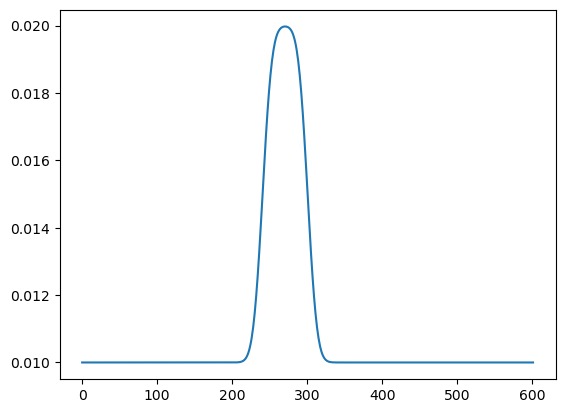

In [7]:
# Plotting
import matplotlib.pyplot as plt

grid = run_simulation2()

fig,ax = plt.subplots()
ax.plot(grid)

In [8]:
%timeit run_simulation2()

313 ms ± 943 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Timing result: 336ms +/- 5ms per loop (mean, st.dev. of 7 runs, 1 loop each)

6. Refactor the diffusion code a second time. This time, eliminate the `for` loops by using [array slicing](https://numpy.org/doc/stable/user/absolute_beginners.html#indexing-and-slicing). This will enable us to use vectorization.

Hint: the loop
```python
for i in range(1, grid_size+1):
    grid[i]
```
will become
```python
grid[1:-1]
```
Drawing a diagram may help you, especially when handling the ghost zones!

In [9]:
def run_simulation3(grid_size = 600, 
                   dt = 0.1,
                   num_iterations = 500,
                   diffusion_coeff = 1.0):
    """
    Simulate the diffusion of a fluid in 1D using lists.
    
    grid_size: the number of cells in our grid.
    dt: time change for each iteration
    num_iterations: how many time steps we allow the fluid to diffuse.
    diffusion_coeff: diffusivity of the fluid; higher is more diffusive.

    Returns the state of the grid after num_iterations
    """

    # Construct 1D grid
    # Add an additional cell at each end to handle grid boundaries
    # grid[0] and grid[grid_size+1] are these boundary cells
    grid = np.zeros(grid_size + 2) + 0.01

    # Set the initial conditions
    # A small region (~10% of total length)
    # near the middle has high concentration
    start_index = int(grid_size * 0.4)
    end_index = int(grid_size * 0.5)
    grid[start_index+1:end_index-1] = 0.02
    
    # Evolve the grid
    for t in range(num_iterations):

        # create a new grid to store updates
        new_grid = np.zeros(grid_size + 2)

        # update main grid
        # for i in range(1, grid_size+1):
        #     stencil = grid[i+1] + grid[i-1] - 2*grid[i]
        #     new_grid[i] = grid[i] + diffusion_coeff * stencil * dt
        stencil = grid[2:] + grid[:-2] - 2*grid[1:-1]
        new_grid[1:-1] = grid[1:-1] + diffusion_coeff * stencil * dt

        # update boundary cells
        new_grid[0] = new_grid[1]
        new_grid[grid_size+1] = new_grid[grid_size]

        # swap new_grid and grid
        grid, new_grid = new_grid, grid
        # if t == 10:
        #     print(grid)

    return grid

7. Time the slice-based code for 500 iterations. How does the speed of this change compare to both our previous versions? Is this what you expect?

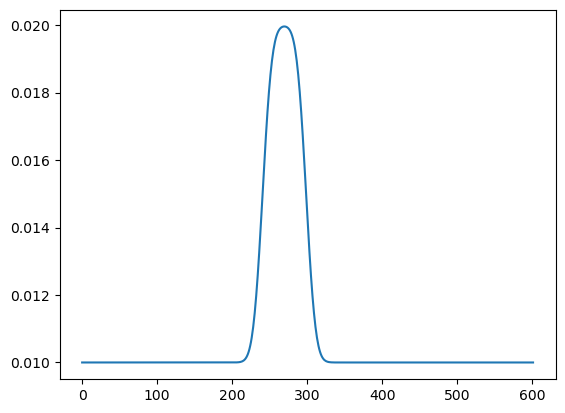

In [10]:
grid = run_simulation3()

fig,ax = plt.subplots()
ax.plot(grid)

In [33]:
%timeit run_simulation3()

10.6 ms ± 53.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Timing results: 10.6ms +/- 53.4us per loop (mean, st.dev. of 7 runs, 100 loops each). This is about a 5x speedup over the original function implementation; this kind of significant speedup is expected due to vectorization.

8. There is one last easy refactor we can do (if you are familiar with this style of algorithm, you may have already spotted it). Profile the vectorized 1D diffusion code and consider the lines with multiple hits. We have been able to reduce the time spent on some of these lines thanks to vectorization. Another strategy is simply to reduce the number of times a line is executed! Which line can benefit from this kind of optimization without breaking the algorithm?

In [34]:
%lprun -f run_simulation3 run_simulation3()

Timer unit: 1e-09 s

Total time: 0.0179236 s
File: /tmp/local/43725233/ipykernel_2798291/3005284909.py
Function: run_simulation3 at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def run_simulation3(grid_size = 600, 
     2                                                              dt = 0.1,
     3                                                              num_iterations = 500,
     4                                                              diffusion_coeff = 1.0):
     5                                               """
     6                                               Simulate the diffusion of a fluid in 1D using lists.
     7                                               
     8                                               grid_size: the number of cells in our grid.
     9                                               dt: time change for each iteration
    10                                          

The `new_grid` variable should actually not be needed, because `new_grid` never references itself after being modified unless it represents exactly what would've been in `grid`. Therefore, we can refactor the code to only directly reference `grid`.

9. Refactor the code a final time to implement the optimization identified above. Compared to the *original* version, what is the final factor of speed-up achieved?

In [11]:
def run_simulation4(grid_size = 600, 
                   dt = 0.1,
                   num_iterations = 500,
                   diffusion_coeff = 1.0):
    """
    Simulate the diffusion of a fluid in 1D using lists.
    
    grid_size: the number of cells in our grid.
    dt: time change for each iteration
    num_iterations: how many time steps we allow the fluid to diffuse.
    diffusion_coeff: diffusivity of the fluid; higher is more diffusive.

    Returns the state of the grid after num_iterations
    """

    # Construct 1D grid
    # Add an additional cell at each end to handle grid boundaries
    # grid[0] and grid[grid_size+1] are these boundary cells
    grid = np.zeros(grid_size + 2) + 0.01

    # Set the initial conditions
    # A small region (~10% of total length)
    # near the middle has high concentration
    start_index = int(grid_size * 0.4)
    end_index = int(grid_size * 0.5)
    grid[start_index+1:end_index-1] = 0.02
    
    # Evolve the grid
    for t in range(num_iterations):

        # update main grid
        stencil = grid[2:] + grid[:-2] - 2*grid[1:-1]
        grid[1:-1] = grid[1:-1] + diffusion_coeff * stencil * dt

        # update boundary cells
        grid[0] = grid[1]
        grid[grid_size+1] = grid[grid_size]

        # swap new_grid and grid
        # grid, new_grid = new_grid, grid
        # if t == 10:
        #     print(grid)

    return grid

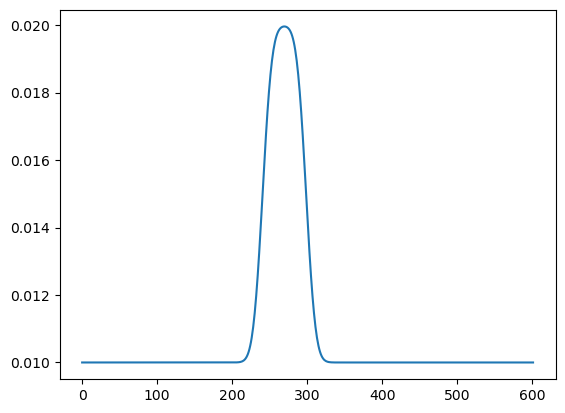

In [12]:
grid4 = run_simulation4()

fig,ax = plt.subplots()
ax.plot(grid4)

In [39]:
%timeit run_simulation4()

9.61 ms ± 103 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Timing result: 9.61ms +/- 103us per loop (mean, st.dev. of 7 runs, 100 loops each). This represents a speedup of about 5.2x compared to the original version of the diffusion simulation.

---
## Operating on Pandas Rows

Pandas is a library that provides data structures and tools for manipulating complex datasets. The most commonly used data structure is the DataFrame. A common analogy for DataFrames is a spreadsheet.

The dataset `customer_hours.csv` contains a large amount (100,000 rows) of fake data representing customer cell phone call time over a two week period. The first column is the customer's unqiue ID number and each subsequent column is the number of hours the customer has spent on a call that day. We're interested in the general trend of each customer's cell usage: does it change over the two weeks or stay largely the same?

To do this, we can use ordinary least squares (OLS) to fit a line $y=mx+b$ to each customer's fake cell phone data. Row-by-row operations like this are commonly applied to Pandas DataFrames. Since we're only interested in how cell phone usage changes over time, we only need the slope $m$ from the OLS fit.

There are two parts to this task where we can explore performance: first, we need a function for performing OLS. Second, we need to apply this function to each row in the DataFrame.

### Ordinary Least Squares

OLS is an incredibly common algorithm, so much so that NumPy, SciPy, and scikit-learn all have their own implementations. How do they compare against each other? Using the following code as setup, you'll write and test a "wrapper" for NumPy's [`lstsq`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html), SciPy's [`linregress`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html), and scikit-learn's [`LinearRegression` class](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

In [2]:
import pandas as pd
from numpy.linalg import lstsq 
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression

df = pd.read_csv("customer_data.csv", index_col="CustomerID")
test_row = df.iloc[0]

For reference, **the resulting slope should be around -0.0117.**

---
#### Exercises

1. Write wrapper functions for each of the routines named above. Each wrapper should take a row from a Pandas DataFrame as input and return the slope of the fitted line. Reference the documentation linked above as needed. 

Notes:
* For simplicity, you may use integers to represent the days (the independent variable) rather than the calendar date in the column label; e.g.,  `x = np.arange(row.shape[0])`. 
* Even if you don't fully understand what NumPy's `lstsq` is doing, the example matches well to our problem.
* scikit-learn is intended to be used for machine learning. The documentation references values `n_features` and `n_targets`; for our purposes, these are each 1. Additionally, the `y` value for the `fit` method is the unmodified data from `row`.

In [8]:
def npls(data):
    A = np.stack((np.arange(data.shape[0]),np.ones(data.shape[0])),axis=1)
    param,_ = lstsq(A,data,rcond=None)[0]
    return param

def scls(data):
    param = linregress(np.arange(data.shape[0]),data)[0]
    return param

def skls(data):
    A = np.stack((np.arange(data.shape[0]),np.ones(data.shape[0])),axis=1)
    param = LinearRegression().fit(A,data).coef_[0]
    return param

2. Time each function using `test_row`. Which method is fastest? Which is slowest?

In [22]:
%timeit npls(test_row)

124 μs ± 702 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [83]:
%timeit scls(test_row)

1.02 ms ± 6.06 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [84]:
%timeit skls(test_row)

745 μs ± 5.51 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


The NumPy method is fastest at a mean of of 115us, and the SciPy method is the slowest, with a mean runtime of 1.02ms

3. SciPy *also* offers a `lstsq` function in it's linear algebra module: `scipy.linalg.lstsq`. In fact, SciPy offers a number of ways to tackle our linear fitting problem. SciPy's `lstsq` behaves very similarly to NumPy's `lstsq`. Create a new wrapper for SciPy's `lstsq` based on your NumPy function.

In [4]:
from scipy.linalg import lstsq as sc_lstsq

In [9]:
def scls2(data):
    M = np.stack((np.arange(data.shape[0]),np.ones(data.shape[0])),axis=1)
    param,_ = sc_lstsq(M,data)[0]
    return param

4. Time the SciPy `lstsq` wrapper. How does it compare to the NumPy version? Using Google, can you find an explanation of the difference?

In [21]:
%timeit scls2(test_row)

161 μs ± 479 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


The SciPy `lstsq` wrapper is slightly slower than the NumPy version, though still significantly faster than the other alternatives. This is because NumPy uses an updated version of a routine that is more time-performant, but requires more memory workspace.

5. In your opinion, which was the *easiest* OLS version to implement? How does the performance of this version compare to the others? Do you think this approach is a good compromise between performance and ease of use?

I think the easiest to implement was SciPy's `linregress` mostly because it assumed the linearity of the model instead of requiring the input "observation" matrix. However, this had the worst performance. I think for small datasets, this could be a worthwhile tradeoff, but when dealing with large amounts of data, it is definitely worth sacrificing ease of implementation to get more performant code.

6. Let's find out why scikit-learn had the slowest OLS implementation. Profile `LinearRegression`'s fitting function using `lprun`. The `LinearRegression.fit` function is itself wrapped (that's what the `@` statement in the source code above the function definition indicates) so your call to `lprun` will need to look like `%lprun -f LinearRegression.fit.__wrapped__ <scikit-learn OLS wrapper>` (if you don't include the `__wrapped__` portion, `line_profiler` will likely suggest it near the top of your output). Which lines dominate the runtime by percentage?

In [24]:
%lprun -f LinearRegression().fit.__wrapped__ skls(test_row)

Timer unit: 1e-09 s

Total time: 0.00242196 s
File: /mnt/ufs18/home-051/dulamatt/miniforge3/envs/hpc-python/lib/python3.12/site-packages/sklearn/linear_model/_base.py
Function: fit at line 581

Line #      Hits         Time  Per Hit   % Time  Line Contents
   581                                               @_fit_context(prefer_skip_nested_validation=True)
   582                                               def fit(self, X, y, sample_weight=None):
   583                                                   """
   584                                                   Fit linear model.
   585                                           
   586                                                   Parameters
   587                                                   ----------
   588                                                   X : {array-like, sparse matrix} of shape (n_samples, n_features)
   589                                                       Training data.
   590                    

Lines 609 and 629 dominate the runtime, which are methods to validate and pre-process the data

7.  Looking at the page for the [`LinearRegression` documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression), you'll see a link called "source" near the top of the page. Clicking this link will take you to the line in the source code where `LinearRegression` is implemented! You can then click on other functions to see where they are implemented using the righthand sidebar. Use this to help you determine the purpose of the functions you identified above.

The functions above seem to be designed to ensure that the function can handle a wider variety of input types by checking the inputs and adjusting accordingly.

8. Having done some investigating, why do you think scikit-learn has the slowest OLS algorithm? Even though it makes their code slow, why might the scikit-learn developers have chosen to write their function this way? What benefit does it provide users of scikit-learn?

I think that the benefit of this approach to writing the code is that it inherently checks the data to make sure that it fits whatever assumptions they are desiring to make about it, and instead of spitting out error messages if the assumptions are violated, it processes the data appropriately. This ultimately makes the implementation more robust, though slower.

### Applying Functions to Rows

We've tested several functions for performing OLS on a row, now it's time to apply it to all rows in `customer_data.csv`.
We'll compare a "purely Pythonic" approach with the tools provided by Pandas.

For the following exercises, use the NumPy `lstsq` wrapper you wrote above.

---
#### Exercises

1. The most natively Pythonic approach is to use a `for` loop to iterate over the rows' numerical indices; i.e., to iterate through `range(df.shape[0])`. The rows can then be accessed by `df.iloc[i]` where `i` is the numerical index. Write a loop that applies your NumPy OLS wrapper to each row in the DataFrame we loaded earlier and collects each row's results in *either* a list or a NumPy array (you decide!). Then, time how long this loop takes to execute.

In [29]:
%%timeit
results = np.empty(df.shape[0])
for i in range(df.shape[0]):
    results[i] = npls(df.iloc[i])

17.5 s ± 102 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Timing result: 17.5 seconds

2. Pandas offers the [`df.apply()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) method which can apply a given function along either every column (`index=0`) or along every row (`index=1`). This function eliminates the need for a `for` loop, and automatically collects the results of our function. Implement `df.apply` and time how long it takes to execute.

In [31]:
%%timeit
results = df.apply(npls,axis=1)

13.6 s ± 13.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Timing result: 13.6 seconds

3. By default, `df.apply()` creates a separate Pandas Series object for each row. This is useful if we want to use Pandas' features in the function we are applying, like indexing by column name; yet, our OLS wrappers don't use any Pandas-specific features. We can access the raw underlying NumPy array with the `raw=True` argument. Add this argument to `df.apply()` and time the result.

In [32]:
%%timeit
results = df.apply(npls,axis=1,raw=True)

8.23 s ± 250 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Timing result: 8.2 seconds

4. Does the `raw=True` argument in `df.apply()` lead to speed up for other kinds of wrappers? That is, do other OLS implementations benefit form working with the raw NumPy array? Pick one or more of your other wrappers and time them with and without `raw=True`.

In [12]:
%%timeit
results = df.apply(scls2,axis=1,raw=False)

15.3 s ± 38.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%%timeit
results = df.apply(scls2,axis=1,raw=True)

11.3 s ± 24.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


From the `scipy.linalg.lstsq` wrapper: other implementations do seem to benefit from working with the raw NumPy array, though it would likely be dependent on the exact implementation. The SciPy `lstsq` examined here is built off of many NumPy functions.

## Wrap-Up Reflection

The material we've covered in the last two weeks follows a particular theme: general-purpose, broadly-applicable data structures and functions versus programming tools built for comparatively narrowly-focused, specific goals. Give an example of what you consider to be a general tools vs a specialized one; there is no firm definition! In your opinion, what are the advantages of using more general tools and what are the advantages of using specialized tools?

Generalized tools in my mind are those such as lists (inlcuding operations such as list comprehension) and dataframes. These are "general" because they can be used in many situations, holding a variety of data types, and are easily adaptable if you wanted to define a function or program to work with many different kinds of data. However, general tools tend to be less efficient, so I would say that the benefit of specialized tools, such as NumPy arrays and vectorized operations, is a significant gain in efficiency, but at the cost of variety. The phrase "jack of all trades, master of none" encapsulates this idea; lists can be used decently well to perform all manner of operations, but for numeric problems, NumPy will almost certainly provide better implementation options.

## For Next Class

Next week we'll start working with multiple CPU cores. A common way to do this is to use *threads* - multiple streams of program execution that share memory. It's this shared memory aspect that makes threads an attractive way to run a program on multiple CPUs; however, Python's design means threads aren't as helpful as they are in other languages. This design feature is called the Global Interpreter Lock (GIL), and the following pre-class resources are intended to make you more familiar with this parallel programming roadblock.

* What is an interpreter anyway? Read this overview of [compiled vs interpreted languages](https://www.freecodecamp.org/news/compiled-versus-interpreted-languages/). The article points out that Python can be run in compiled mode (if you've ever seen a `.pyc` file, that's compiled Python code) but this is usually reserved for imported modules.
* Watch this video [introducing the GIL](https://www.youtube.com/watch?v=XVcRQ6T9RHo).
* Read this article explaining [why the GIL is necessary](https://realpython.com/python-gil/).
* **Optional:** a recent Python Enhancement Proposal (PEP) lays out a road map for removing the GIL! If you're interested, you can read more [here](https://www.infoworld.com/article/3704248/python-moves-to-remove-the-gil-and-boost-concurrency.html). This proposal is slated to be included with Python 3.13, which is currently in the "pre-release" stage.